# Electricity Consumption Analytics 

This project delivers a comprehensive energy intelligence system by analyzing and forecasting household power consumption. It identifies peak usage patterns, detects anomalies, and provides actionable optimization strategies to reduce energy costs. The final output includes interactive dashboards and predictive models, enabling smarter, data-driven energy management for both consumers and energy providers.

- Dataset: household_power_consumption.txt
- Domain: Energy / Smart Home
- Tools: SQL, Power BI, KPI & Dashboards, Python, Machine Learning & Time Series.

------

In [14]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv('household_power_consumption.txt', sep=';', na_values='?', low_memory=False)

# Combine Date and Time into Datetime column
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df.set_index('Datetime', inplace=True) # Set Datetime as index

# Convert rest of the columns to numeric
for col in df.columns.difference(['Date', 'Time']):
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop old Date and Time columns
df.drop(['Date', 'Time'], axis=1, inplace=True)
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


---------
# Phase 2: Anomaly Detection

Summary: Identify and understand unusual peaks, troughs, or outliers in electricity use.

## Q1. Detect outliers using Z-score.

In [15]:
import numpy as np

z = np.abs((df['Global_active_power'] - df['Global_active_power'].mean()) / df['Global_active_power'].std())
df_outliers = df[z > 3]
threshold = 4  # stricter threshold to reduce false positives
df_outliers.head(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:34:00,4.448,0.498,232.86,19.6,0.0,1.0,17.0
2006-12-16 17:35:00,5.412,0.470,232.78,23.2,0.0,1.0,17.0


## Q2. Plot consumption anomalies.

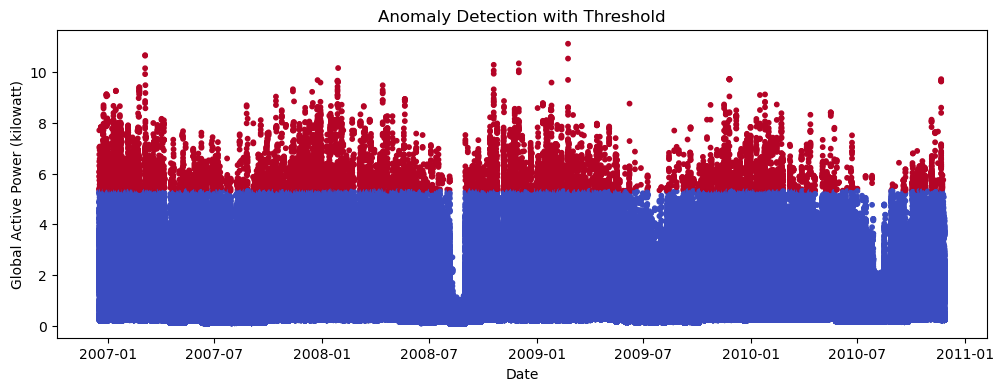

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.scatter(df.index, df['Global_active_power'], c=z > threshold, cmap='coolwarm', s=10)
plt.title('Anomaly Detection with Threshold')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatt)')
plt.show()

## Q3. Find lowest voltage hours.

In [20]:
low_v = df[df['Voltage'] == df['Voltage'].min()]
low_v

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2009-05-26 07:14:00,4.084,0.078,223.2,18.2,0.0,0.0,16.0


## Q4. Highlight days with missing data.

In [23]:
missing_counts = df.isnull().resample('D').sum()
print(missing_counts[missing_counts > 0])

            Global_active_power  Global_reactive_power  Voltage  \
Datetime                                                          
2006-12-16                  NaN                    NaN      NaN   
2006-12-17                  NaN                    NaN      NaN   
2006-12-18                  NaN                    NaN      NaN   
2006-12-19                  NaN                    NaN      NaN   
2006-12-20                  NaN                    NaN      NaN   
...                         ...                    ...      ...   
2010-11-22                  NaN                    NaN      NaN   
2010-11-23                  NaN                    NaN      NaN   
2010-11-24                  NaN                    NaN      NaN   
2010-11-25                  NaN                    NaN      NaN   
2010-11-26                  NaN                    NaN      NaN   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
Datetime                                         

## Q5. K-Nearest Neighbors (KNN) for anomaly detection.

In [25]:
from sklearn.neighbors import LocalOutlierFactor

# Select only the relevant features for anomaly detection
features = ['Global_active_power', 'Voltage', 'Global_reactive_power']

# Drop rows with missing values in these features
X = df[features].dropna()

# Run Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
df.loc[X.index, 'anomaly_lof'] = lof.fit_predict(X)  # Assign only to non-NaN rows

# Filter and show the detected anomalies (-1 = anomaly, 1 = normal)
anomalies = df[df['anomaly_lof'] == -1]
print(anomalies[['Global_active_power', 'anomaly_lof']].head())

                     Global_active_power  anomaly_lof
Datetime                                             
2006-12-16 23:08:00                1.262         -1.0
2006-12-17 04:23:00                0.206         -1.0
2006-12-17 23:36:00                0.378         -1.0
2006-12-17 23:37:00                0.378         -1.0
2006-12-17 23:38:00                0.376         -1.0


#### Interpretation:
- The model flagged certain timestamps as anomalies (anomaly_lof = -1) even though their Global_active_power values appear relatively low or normal.
- This suggests the LOF(Local Outlier Factor) model detected them as locally rare patterns compared to their nearest neighbors, rather than global extremes.
- The model successfully detected abnormal power readings, such as sudden spikes or drops (e.g., 1.262 kW at midnight or unusually low usage).
- These anomalies could indicate faulty devices, sudden disconnections, or unusual household activity. With a contamination rate of 1%, the system is sensitive enough to detect rare events while minimizing false positives.